# Capstone project: Fucntion 5

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from scipy.stats import norm

ModuleNotFoundError: No module named 'bayes_opt'

## Description of function 5

You’re tasked with optimising a four-variable black-box function that represents the yield of a chemical process in a factory. The function is typically unimodal, with a single peak where yield is maximised. 

Your goal is to find the optimal combination of chemical inputs that delivers the highest possible yield, using systematic exploration and optimisation methods.

Input parameters 4D array (20,4), output array 1D (20,1)

### Step 1: Load in the data 

In [2]:
X = np.load('initial_inputs.npy')
y = np.load('initial_outputs.npy')

inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

print(X,y)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]] [6.44434399e+01 1.83013796e+01 1.12939795e-01 4.21089813e+0

### Step 2: Fit surrogate model - Gaussian process

In [13]:
kernel = Matern(length_scale=np.ones(4)*0.2, nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=0)
gp.fit(X, y)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.2, 0.2, 0.2, 0.2], nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

### Step 3: Use acquisition function - this case we will use ei with bayes_opt

In [20]:
def gp_predict(x1, x2, x3, x4):
    X_new = np.array([[x1, x2, x3, x4]]) 
    mu = gp.predict(X_new, return_std=False)[0] 
    return mu

pbounds = {'x1': (0, 1), 'x2': (0, 1), 'x3': (0, 1), 'x4': (0, 1)} 

# Initialize the optimizer
optimizer = BayesianOptimization(
    f=gp_predict,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=5,
    n_iter=20,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
| 1         | 301.47141 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 |
| 2         | 621.42587 | 0.1560186 | 0.1559945 | 0.0580836 | 0.8661761 |
| 3         | 12.710330 | 0.6011150 | 0.7080725 | 0.0205844 | 0.9699098 |
| 4         | 53.420519 | 0.8324426 | 0.2123391 | 0.1818249 | 0.1834045 |
| 5         | 45.113414 | 0.3042422 | 0.5247564 | 0.4319450 | 0.2912291 |
| 6         | 53.985934 | 0.7851759 | 0.1521478 | 0.3854241 | 0.4755587 |
| 7         | 141.13265 | 0.0321495 | 0.0373869 | 0.0196432 | 0.9205034 |
| 8         | -5.976112 | 0.4595347 | 0.2023637 | 0.0905323 | 0.3150392 |
| 9         | 55.267867 | 0.5190062 | 0.1210248 | 0.0783976 | 0.1007623 |
| 10        | 129.12230 | 0.5252922 | 0.1595421 | 0.8260930 | 0.7434306 |
| 11        | 198.55011 | 0.9490182 | 0.9802613 | 0.6089563 | 0.4980354 |
| 12        | 622.02628 | 0.2548748 | 

In [25]:
print("Next candidate to test (predicted to give highest yield)") 
print(optimizer.max['params']) 
print("Predicted yield:", optimizer.max['target'])

Next candidate to test (predicted to give highest yield)
{'x1': np.float64(0.26824227411879514), 'x2': np.float64(0.26199266174180136), 'x3': np.float64(0.1004673019775704), 'x4': np.float64(0.8190727737893138)}
Predicted yield: 926.4246873772609


# ********* Week 2 update and optimisation *************

## Step 1: Load in new data

In [2]:

inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Inputs_Outputs/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F5_inputs_week2 = inputs_week2[4]
F5_outputs_week2 = outputs_week2[4]



# Step 5: merge with previous data
F5_inputs_week2 = F5_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F5_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F5_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

#Save results 
np.save('inputs_week2.npy',inputdata_week2)
np.save('outputs_week2.npy',outputdata_week2)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.268242   0.261993   0.100467   0.819073  ]]
[6.44434399e

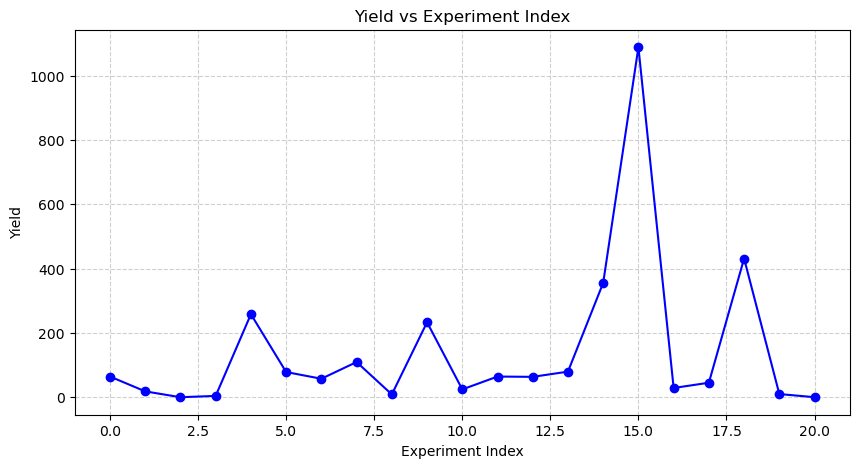

Best parameters: [0.22418902 0.84648049 0.87948418 0.87851568]
Best yield: 1088.8596181962705


<Figure size 640x480 with 0 Axes>

In [13]:
## Plot the outputs to see how it is doing


indices = np.arange(len(outputdata_week2))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week2, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week2)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

plt.savefig('function5_wk2.png')


## step 2: Update where we search based on this information and update surrogate model to focus on exploitation

In [10]:
#Focus sampling around best candidates 

search_radius = 0.1  # 10% of normalized parameter range
lower_bound = np.maximum(0, best_x - search_radius)
upper_bound = np.minimum(1, best_x + search_radius)  # assuming parameters are scaled [0,1]

print("Focused search bounds:")
print("Lower:", lower_bound)
print("Upper:", upper_bound)

# Sample new candidate points within this region
n_candidates = 100
X_new_candidates = np.random.uniform(lower_bound, upper_bound, size=(n_candidates, 4))


# Fit surrogate model 
# Predict GP mean and std
mu, sigma = gp.predict(X_new_candidates, return_std=True)

# Expected Improvement (EI) or UCB
from scipy.stats import norm

y_best = best_y
EI = (mu - y_best) * norm.cdf((mu - y_best)/sigma) + sigma * norm.pdf((mu - y_best)/sigma)


Focused search bounds:
Lower: [0.12418902 0.74648049 0.77948418 0.77851568]
Upper: [0.32418902 0.94648049 0.97948418 0.97851568]


## Step 3: Identify next points

In [12]:
next_idx = np.argmax(EI)
x_next = X_new_candidates[next_idx]
print("Next parameters to evaluate (focused exploit):", np.round(x_next,6))

Next parameters to evaluate (focused exploit): [0.247966 0.858681 0.977502 0.905284]


# ********* Week 3: Further data update and optimisation ***********

### Step 1: Load in the new data for optimisation

In [3]:
#Load in original input and output data 
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F5_inputs_week3 = inputs_week3[4]
F5_outputs_week3 = outputs_week3[4]


# Step 5: merge with previous data
F5_inputs_week3 = F5_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F5_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F5_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

# Save the results of these
np.save('inputs_week3.npy',inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.268242   0.261993   0.100467   0.819073  ]
 [0.247966   

### Step 2: Plot the results of your optimisation so far

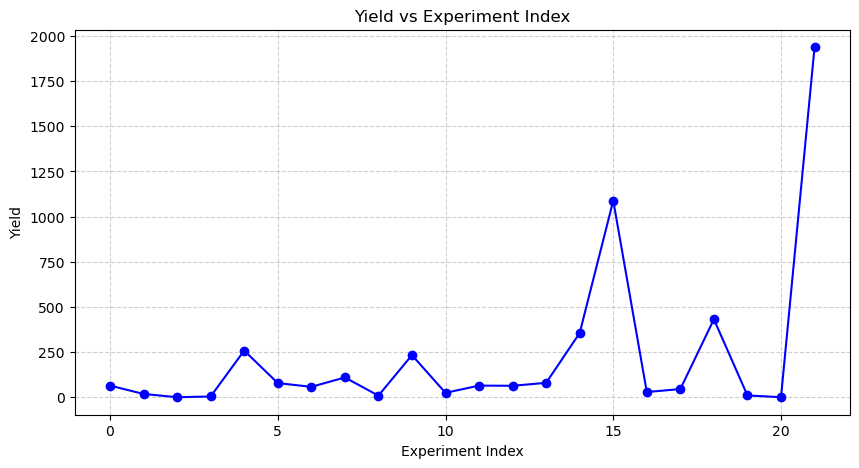

Best parameters: [0.247966 0.858681 0.977502 0.905284]
Best yield: 1937.9912645012148


<Figure size 640x480 with 0 Axes>

In [4]:
## Plot the outputs to see how it is doing

indices = np.arange(len(outputdata_week3))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week3, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week3)
best_x = inputdata_week3[best_idx]
best_y = outputdata_week3[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

plt.savefig('function5_wk3.png')

### Step 3: Update surrogate model -GP with new data

In [9]:
X_wk3=inputdata_week3
y_wk3=outputdata_week3

#Focus sampling around best candidates 
search_radius = 0.1  # 10% of normalized parameter range
lower_bound = np.maximum(0, best_x - search_radius)
upper_bound = np.minimum(1, best_x + search_radius)  # assuming parameters are scaled [0,1]

print("Focused search bounds:")
print("Lower:", lower_bound)
print("Upper:", upper_bound)

# Sample new candidate points within this region
n_candidates = 100
X_new_candidates = np.random.uniform(lower_bound, upper_bound, size=(n_candidates, 4))


# Fit surrogate model 
# Predict GP mean and std
kernel = Matern(length_scale=np.ones(4)*0.2, nu=2.5) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=0)
gp.fit(X_wk3, y_wk3)
mu, sigma = gp.predict(X_new_candidates, return_std=True)

# Expected Improvement (EI) or UCB
from scipy.stats import norm

y_best = best_y
EI = (mu - y_best) * norm.cdf((mu - y_best)/sigma) + sigma * norm.pdf((mu - y_best)/sigma)


Focused search bounds:
Lower: [0.147966 0.758681 0.877502 0.805284]
Upper: [0.347966 0.958681 1.       1.      ]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [10]:
next_idx = np.argmax(EI)
x_next = X_new_candidates[next_idx]
print("Next parameters to evaluate (focused exploit):", np.round(x_next,6))

Next parameters to evaluate (focused exploit): [0.215972 0.942382 0.991616 0.975899]


# ****** Week 4 - Updated data *******

## Step 1: Upload new data points

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F5_inputs_week4 = inputs_week4[4]
F5_outputs_week4 = outputs_week4[4]


# Step 5: merge with previous data
F5_inputs_week4 = F5_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F5_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F5_outputs_week4])))

print(inputdata_week4)
print(outputdata_week4)

# Save the results of these
np.save('inputs_week4.npy',inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.268242   0.261993   0.100467   0.819073  ]
 [0.247966   

## Step 2: Visualise the results

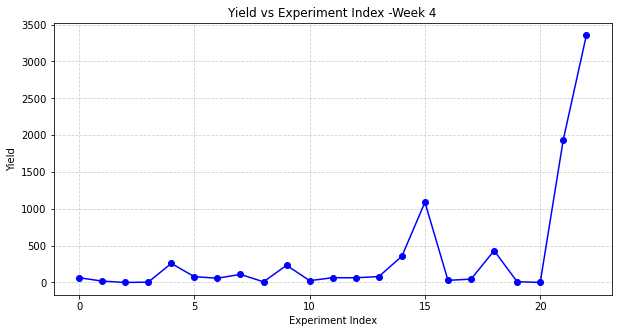

Best parameters: [0.215972 0.942382 0.991616 0.975899]
Best yield: 3354.9201566963015


<Figure size 432x288 with 0 Axes>

In [4]:
## Plot the outputs to see how it is doing

indices = np.arange(len(outputdata_week4))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week4, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 4')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week4)
best_x = inputdata_week4[best_idx]
best_y = outputdata_week4[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

plt.savefig('function5_wk4.png')

## Step 3: Fit GP with new data

In [5]:
# Fit Gaussian Process
X_wk4=inputdata_week4
y_wk4=outputdata_week4

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk4, y_wk4)

GaussianProcessRegressor(alpha=1e-06, kernel=Matern(length_scale=0.5, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

In [6]:
# Generate candidate points in 4D
X_candidates = np.random.rand(5000, 4)

# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)



## Step 4: Update acquisition function -EI

In [13]:
# Expected Improvement acquisition
from scipy.stats import norm

y_max = y_wk4.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next input combination to try
x_next = X_candidates[np.argmax(EI)]
print("Next input combination to test:", np.round(x_next,6))

Next input combination to test: [0.087444 0.992775 0.983949 0.977697]


# ***** Week 5: Updated data ********

## Step 1: Load in data

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F5_inputs_week5 = inputs_week5[4]
F5_outputs_week5 = outputs_week5[4]


# Step 5: merge with previous data
F5_inputs_week5 = F5_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F5_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F5_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

# Save the results of these
np.save('inputs_week5.npy',inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.268242   0.261993   0.100467   0.819073  ]
 [0.247966   

## Step 2: Plot the output 

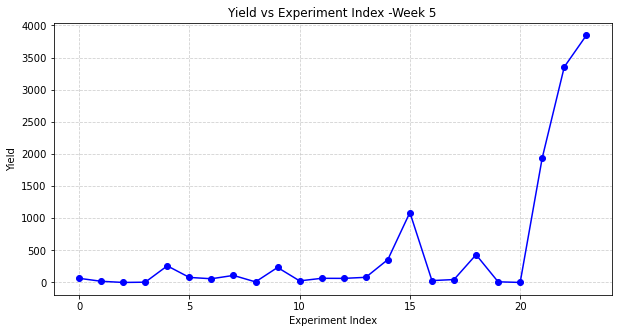

Best parameters: [0.087444 0.992775 0.983949 0.977697]
Best yield: 3846.254238971455


<Figure size 432x288 with 0 Axes>

In [3]:
## Plot the outputs to see how it is doing

indices = np.arange(len(outputdata_week5))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week5, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 5')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week5)
best_x = inputdata_week5[best_idx]
best_y = outputdata_week5[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

plt.savefig('function5_wk5.png')

## Step 3: Update GP surrogate model

In [4]:
# Fit Gaussian Process
X_wk5=inputdata_week5
y_wk5=outputdata_week5

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk5, y_wk5)

GaussianProcessRegressor(alpha=1e-06, kernel=Matern(length_scale=0.5, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

In [5]:
# Generate candidate points in 4D
X_candidates = np.random.rand(5000, 4)

# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)


## Step 4: Update acquisition function

In [6]:
# Expected Improvement acquisition
from scipy.stats import norm

y_max = y_wk5.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next input combination to try
x_next = X_candidates[np.argmax(EI)]
print("Next input combination to test:", np.round(x_next,6))

Next input combination to test: [0.984031 0.99992  0.772333 0.957409]


# **** Week 6 *****

## Step 1: Upload updated data

In [3]:
#Load in original input and output data 
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F5_inputs_week6 = inputs_week6[4]
F5_outputs_week6 = outputs_week6[4]


# Step 5: merge with previous data
F5_inputs_week6 = F5_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F5_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F5_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

# Save the results of these
np.save('inputs_week6.npy',inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.268242   0.261993   0.100467   0.819073  ]
 [0.247966   

## Step 2: Plot output data

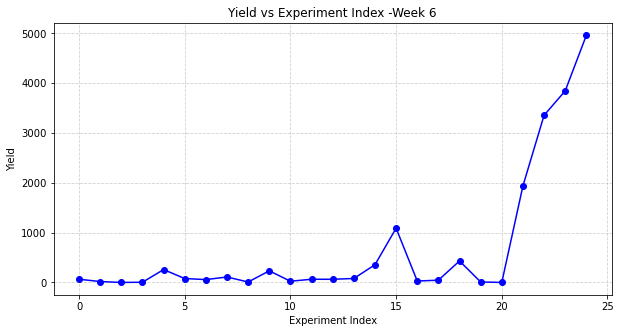

Best parameters: [0.984031 0.99992  0.772333 0.957409]
Best yield: 4960.496180536462


<Figure size 432x288 with 0 Axes>

In [4]:
## Plot the outputs to see how it is doing

indices = np.arange(len(outputdata_week6))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week6, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 6')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week6)
best_x = inputdata_week6[best_idx]
best_y = outputdata_week6[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

plt.savefig('function5_wk6.png')

## Step 3: Update GP surrogate model

In [5]:
# Fit Gaussian Process
X_wk6=inputdata_week6
y_wk6=outputdata_week6

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk6, y_wk6)

GaussianProcessRegressor(alpha=1e-06, kernel=Matern(length_scale=0.5, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=42)

## Step 4: Acquisition function

In [6]:
# Generate candidate points in 4D
X_candidates = np.random.rand(8000, 4)

# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)

In [7]:
# Expected Improvement acquisition
from scipy.stats import norm

y_max = y_wk6.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next input combination to try
x_next = X_candidates[np.argmax(EI)]
print("Next input combination to test:", np.round(x_next,6))

Next input combination to test: [0.805107 0.996688 0.957124 0.973757]


# ****** Week 7 ******

## Step 1: Upload updated data

In [8]:
#Load in original input and output data 
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F5_inputs_week7 = inputs_week7[4]
F5_outputs_week7 = outputs_week7[4]


# Step 5: merge with previous data
F5_inputs_week7 = F5_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F5_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F5_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

# Save the results of these
np.save('inputs_week7.npy',inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.19144708 0.03819337 0.60741781 0.41458414]
 [0.75865295 0.53651774 0.65600038 0.36034155]
 [0.43834987 0.8043397  0.21024527 0.15129482]
 [0.70605083 0.53419196 0.26424335 0.48208755]
 [0.83647799 0.19360965 0.6638927  0.78564888]
 [0.68343225 0.11866264 0.82904591 0.56757661]
 [0.55362148 0.66734998 0.32380582 0.81486975]
 [0.35235627 0.32224153 0.11697937 0.47311252]
 [0.15378571 0.72938169 0.42259844 0.44307417]
 [0.46344227 0.63002451 0.10790646 0.9576439 ]
 [0.67749115 0.35850951 0.47959222 0.07288048]
 [0.58397341 0.14724265 0.34809746 0.42861465]
 [0.30688872 0.31687813 0.62263448 0.09539906]
 [0.51114177 0.817957   0.72871042 0.11235362]
 [0.43893338 0.77409176 0.37816709 0.93369621]
 [0.22418902 0.84648049 0.87948418 0.87851568]
 [0.72526172 0.47987049 0.08894684 0.75976022]
 [0.35548161 0.63961937 0.41761768 0.12260384]
 [0.11987923 0.86254031 0.64333133 0.84980383]
 [0.12688467 0.15342962 0.77016219 0.19051811]
 [0.268242   0.261993   0.100467   0.819073  ]
 [0.247966   

## Step 2: Visualise the results

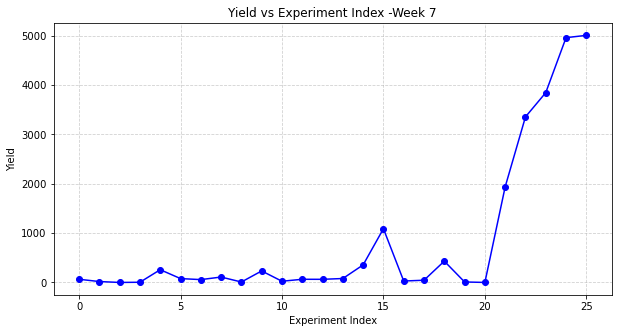

Best parameters: [0.805107 0.996688 0.957124 0.973757]
Best yield: 5007.253839505405


<Figure size 432x288 with 0 Axes>

In [9]:
## Plot the outputs to see how it is doing

indices = np.arange(len(outputdata_week7))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week7, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 7')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week7)
best_x = inputdata_week7[best_idx]
best_y = outputdata_week7[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

plt.savefig('function5_wk7.png')

## Ways to improve this week

### Point 1: The kernel may be too smooth and too restrictive for this problem. Currently this assumes a smooth function but at the edges of optimisation, there are sharp jumps suggesting this needs to be updated.
### Fix 1: Make a rougher/ anisotropic kernel which provides different sensitivity per variable (e.g., ARD)

### Point 2: The scale of Y is huge which may impact the GP making it likely EI will become dominated by large-magnitude regions
### Fix 2: Placing y into log space may help to compress scale and make the peak easier to model.

## Step 3: Update Y scale and GP surrogate model

In [10]:
X_wk7 = inputdata_week7
y_wk7 = outputdata_week7


# Log-transform outputs to stabilise magnitude

y_gp = np.log1p(y_wk7)


# Improved kernel (ARD + sharper curvature)

kernel = Matern(
    length_scale=[0.5, 0.5, 0.5, 0.5],
    length_scale_bounds=(1e-2, 2.0),
    nu=1.5
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,              # unchanged for now
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
)

gp.fit(X_wk7, y_gp)

X_candidates = np.random.rand(5000, 4)

# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)

sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Step 4: Correct y max to same space as GP target and run acquisition function

In [12]:
from scipy.stats import norm

y_max = y_gp.max()

# -----------------------------
# Expected Improvement
# -----------------------------
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# -----------------------------
# Next input to evaluate
# -----------------------------
x_next = X_candidates[np.argmax(EI)]
print("Next input combination to test:", np.round(x_next, 6))

Next input combination to test: [0.243845 0.987179 0.793834 0.99224 ]
